In [1]:
import sys
sys.path.append("..")

from tree_parser import file_contents, meta_math_database

from my_utils import print_proof_props_graph, get_proof_steps, print_ident_proof, print_proof_linear_steps
from my_utils import get_proof_steps_graph, print_proof_steps_graph


from expanding import construct_proof, expand_proof_step_ps

from collections import defaultdict

In [2]:
%%time

text = file_contents("../set.mm")
database = meta_math_database(text,n=3500)

included 5555695 tokens from ../set.mm
proposition: 3500CPU times: user 9.7 s, sys: 251 ms, total: 9.95 s
Wall time: 10.1 s


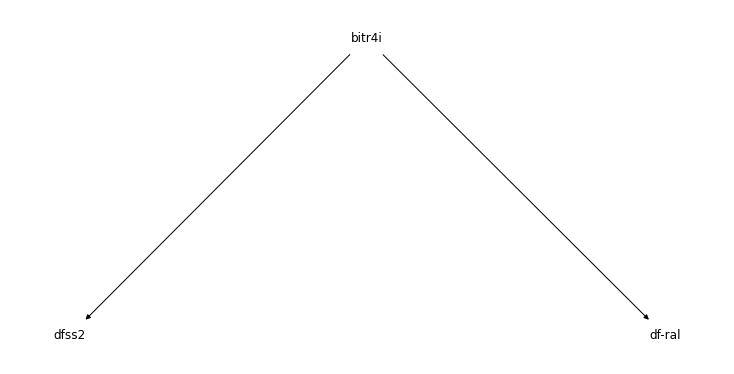

 <PStep:bitr4i ⊢ ( A ⊆ B ↔ ∀ x ∈ A x ∈ B )>
 |  <PStep:dfss2 ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PStep:df-ral ⊢ ( ∀ x ∈ A x ∈ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>


In [13]:
prop = database.propositions["dfss3"]
prop_proof = construct_proof(prop)
prop_proof.print_graph()
prop_proof.print_linear()

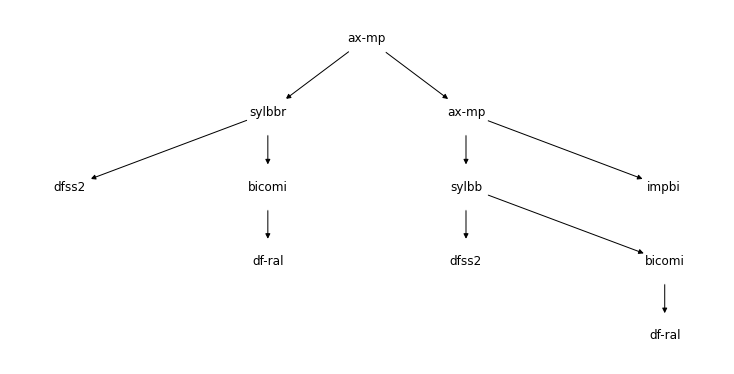

 <PStep:ax-mp ⊢ ( A ⊆ B ↔ ∀ x ∈ A x ∈ B )>
 |  <PStep:sylbbr ⊢ ( ∀ x ∈ A x ∈ B → A ⊆ B )>
 |  |  <PStep:dfss2 ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PStep:bicomi ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ∈ A x ∈ B )>
 |  |  |  <PStep:df-ral ⊢ ( ∀ x ∈ A x ∈ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PStep:ax-mp ⊢ ( ( ∀ x ∈ A x ∈ B → A ⊆ B ) → ( A ⊆ B ↔ ∀ x ∈ A x ∈ B ) )>
 |  |  <PStep:sylbb ⊢ ( A ⊆ B → ∀ x ∈ A x ∈ B )>
 |  |  |  <PStep:dfss2 ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  |  <PStep:bicomi ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ∈ A x ∈ B )>
 |  |  |  |  <PStep:df-ral ⊢ ( ∀ x ∈ A x ∈ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PStep:impbi ⊢ ( ( A ⊆ B → ∀ x ∈ A x ∈ B ) → ( ( ∀ x ∈ A x ∈ B → A ⊆ B ) → ( A ⊆ B ↔ ∀ x ∈ A x ∈ B ) ) )>


In [19]:
prop_proof = prop_proof.expand()
prop_proof.print_graph()
prop_proof.print_linear()

In [12]:
print(prop_proof)
print(prop_proof.inputs)

<PStep:ax-mp ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
[<PStep:sylbbr ⊢ ( ∀ x ( x ∈ A → x ∈ B ) → A ⊆ B )>, <PStep:ax-mp ⊢ ( ( ∀ x ( x ∈ A → x ∈ B ) → A ⊆ B ) → ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) ) )>]


In [29]:
prop_proof.inputs

[<PPHyp:impbii.1 ⊢ ( 𝜑 → 𝜓 )>,
 <PPHyp:impbii.2 ⊢ ( 𝜓 → 𝜑 )>,
 <PPStep:impbi ⊢ ( ( 𝜑 → 𝜓 ) → ( ( 𝜓 → 𝜑 ) → ( 𝜑 ↔ 𝜓 ) ) )>]

In [71]:
[e.prop.label for e in database.propositions["mp2"].entails_proof_steps[1]._prior_entails]

['mp2.2', 'ax-mp']

In [79]:
[h.label for h in prop_proof._step.prop.hyps if h.type == "e"]

['mp2.1', 'mp2.2', 'mp2.3']

In [45]:
database.propositions["mp2"].hyps

[<f_hypothesis wph: wff ph>,
 <f_hypothesis wps: wff ps>,
 <f_hypothesis wch: wff ch>,
 <e_hypothesis mp2.1: |- |-ph>,
 <e_hypothesis mp2.2: |- |-ps>,
 <e_hypothesis mp2.3: |- |-(ph->(ps->ch))>]

In [80]:
def replace_expanded_step2(step, expanded_step):
    # Replace root node
    if step.output != None:
        expanded_step.output = step.output
        step_output_index = step.output.inputs.index(step)
        step.output.inputs[step_output_index] = expanded_step
        
    # Replace hyps
    ## Get hyps out nodes (this is necessary because hyp nodes must be replaced and not connected)
    #expanded_step_hyps = [h.output for h in expanded_step.get_hyps()]
    expanded_step_hyps = expanded_step.get_hyps()
    
    #Since there may be use of the same declared hypothesis twice (like in bitri proof)
    #We need to handle this assigning hyps to a dict
    exp_hyps_dict = defaultdict(list)
    
    
    #We have to take the list of hypothesis this way so we can make sure the 
    #proper order is maintained with the original step inputs order.
    #Using the order returned by the depth first search in expanded_step.get_hyps() 
    #may return problematic orders like in the case of mp2 proposition in the impbii proof
    #This will also work as a sanity checker since we are getting hypothesis labels from diferent
    #places that are expected to match.
    exp_hyps_list = [h.label for h in step._step.prop.hyps if h.type == "e"]
    #exp_hyps_list = [] #We have to use this list to preserve the order where the hyps appear
    
    for exp_hyp in expanded_step_hyps:
        #if exp_hyp.label not in exp_hyps_list: exp_hyps_list.append(exp_hyp.label)
        exp_hyps_dict[exp_hyp.label].append(exp_hyp)
        
    print(exp_hyps_list)
    
    assert len(step.inputs) == len(exp_hyps_list), f"{len(step.inputs)} {step.inputs} {len(exp_hyps_list)} {exp_hyps_list} {len(exp_hyps_dict)} {exp_hyps_dict}"
     
    for step_input, exp_hyp_label in zip(step.inputs, exp_hyps_list):
        print(step_input.label, exp_hyp_label)
        for exp_hyp in exp_hyps_dict[exp_hyp_label]:
            #We have to do this to copy branches where the hypothesis are used twice
            #This will increase the size of the tree however will prevent node crossing
            #while visualizing them, which will help us debug, which is the main goal of this project.
            step_input_cp = step_input.copy()
            step_input_cp.output = exp_hyp.output #(this is necessary because hyp nodes must be replaced and not connected)
            exp_hyp_index = exp_hyp.output.inputs.index(exp_hyp)
            exp_hyp.output.inputs[exp_hyp_index] = step_input_cp
        
    #Return new proof
    #Maybe it is a good idea to perform a deepcopy of every step
    return expanded_step.get_root_step() 


In [81]:
def expand(self):
    exp_self = expand_proof_step_ps(self)

    if exp_self == None: #No more expansions are possible
        return self.get_root_step()

    exp_self_root_step = replace_expanded_step2(self, exp_self)
    return exp_self_root_step

['mp2.1', 'mp2.2', 'mp2.3']
impbii.1 mp2.1
impbii.2 mp2.2
impbi mp2.3


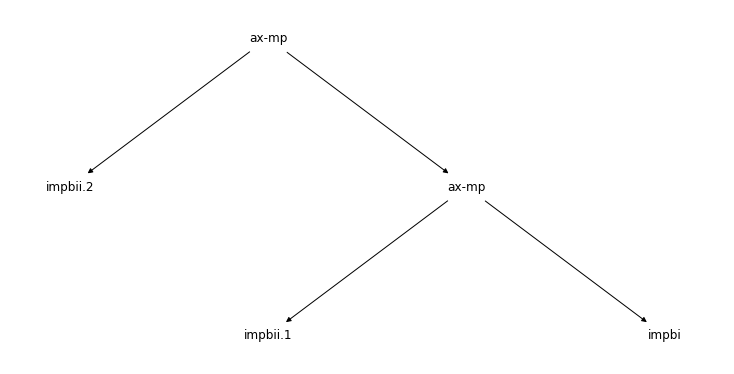

<PPStep:ax-mp ⊢ ( 𝜑 ↔ 𝜓 )>
[<PPHyp:impbii.2 ⊢ ( 𝜓 → 𝜑 )>, <PPStep:ax-mp ⊢ ( ( 𝜓 → 𝜑 ) → ( 𝜑 ↔ 𝜓 ) )>]
 <PPStep:ax-mp ⊢ ( 𝜑 ↔ 𝜓 )>
 |  <PPHyp:impbii.2 ⊢ ( 𝜓 → 𝜑 )>
 |  <PPStep:ax-mp ⊢ ( ( 𝜓 → 𝜑 ) → ( 𝜑 ↔ 𝜓 ) )>
 |  |  <PPHyp:impbii.1 ⊢ ( 𝜑 → 𝜓 )>
 |  |  <PPStep:impbi ⊢ ( ( 𝜑 → 𝜓 ) → ( ( 𝜓 → 𝜑 ) → ( 𝜑 ↔ 𝜓 ) ) )>


In [82]:
prop = database.propositions["impbii"]
prop_proof = construct_proof(prop)

prop_proof = expand(prop_proof)
prop_proof.print_graph()
print(prop_proof)
print(prop_proof.inputs)
prop_proof.print_linear()

In [84]:
prop = database.propositions["dfss2"]
prop_proof = construct_proof(prop)

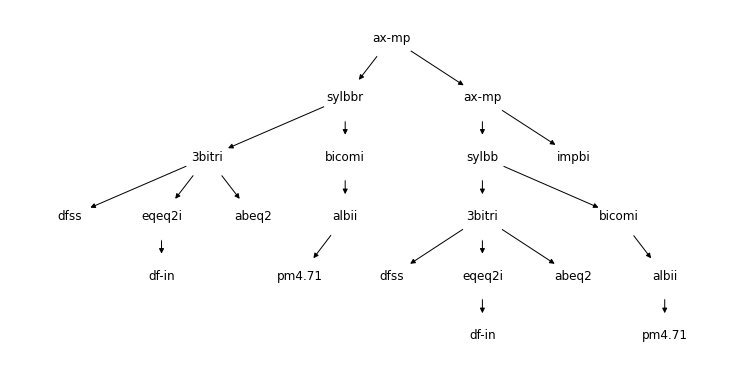

 <PPStep:ax-mp ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:sylbbr ⊢ ( ∀ x ( x ∈ A → x ∈ B ) → A ⊆ B )>
 |  |  <PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  |  <PPStep:eqeq2i ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  |  <PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  |  <PPStep:abeq2 ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PPStep:bicomi ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  |  <PPStep:albii ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  |  <PPStep:pm4.71 ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PPStep:ax-mp ⊢ ( ( ∀ x ( x ∈ A → x ∈ B ) → A ⊆ B ) → ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) ) )>
 |  |  <PPStep:sylbb ⊢ ( A ⊆ B → ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  |  <PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ 

In [90]:
prop_proof = expand(prop_proof)
prop_proof.print_graph()
prop_proof.print_linear()

<PPStep:eqeq2i ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>


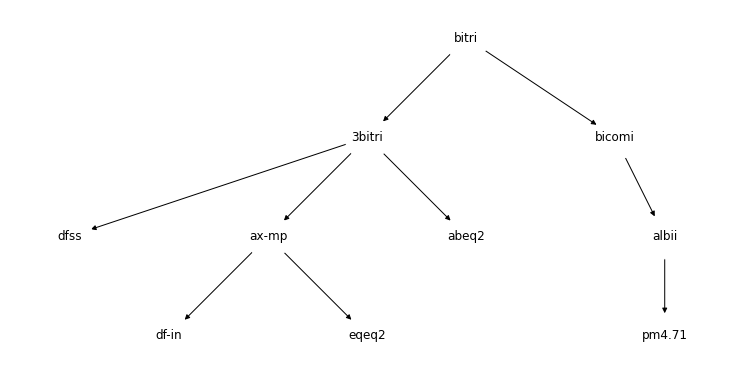

In [7]:
_p_step = prop_proof.inputs[0].inputs[1]
print(_p_step)
prop_proof = _p_step.expand()
prop_proof.print_graph()

<PPStep:abeq2 ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>


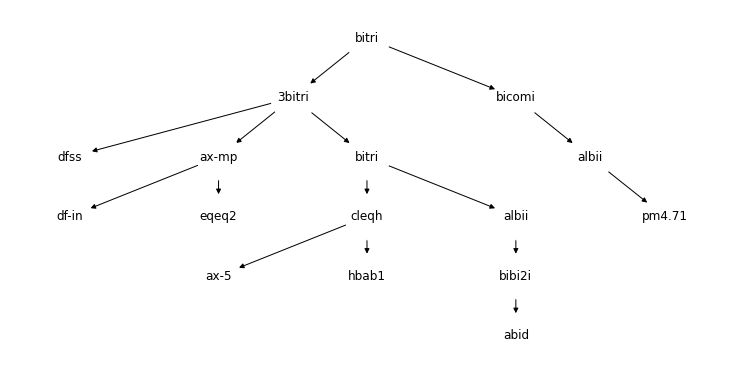

In [8]:
_p_step = prop_proof.inputs[0].inputs[2]
print(_p_step)
prop_proof = _p_step.expand()
prop_proof.print_graph()

<PPStep:cleqh ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ x ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) )>


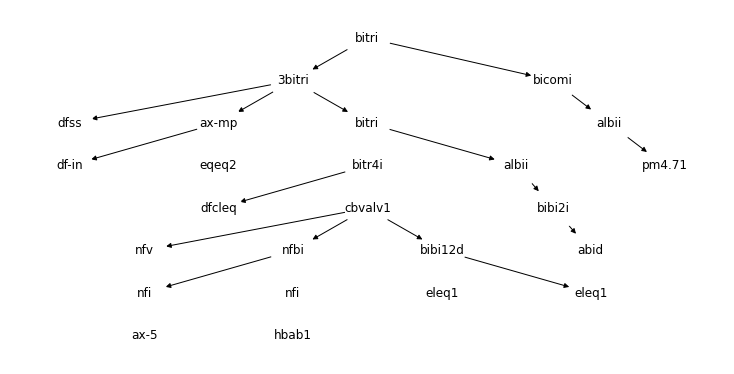

In [9]:
_p_step = prop_proof.inputs[0].inputs[2].inputs[0]
print(_p_step)
prop_proof = _p_step.expand()
prop_proof.print_graph()

In [10]:
prop_proof.inputs[0].inputs[1]

<PPStep:ax-mp ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>

In [11]:
prop_proof.inputs[0].inputs[1].inputs

[<PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>,
 <PPStep:eqeq2 ⊢ ( ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) } → ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } ) )>]

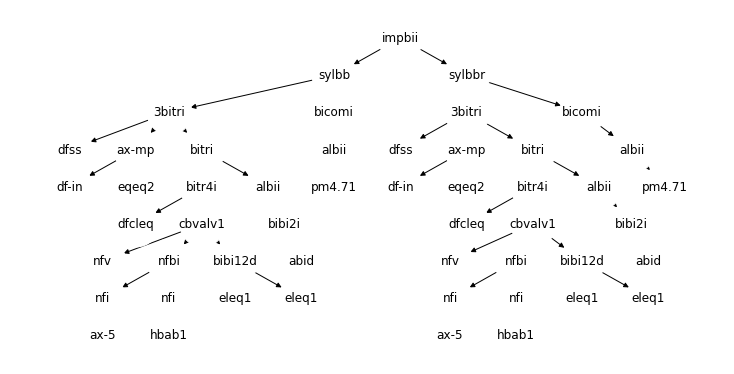

In [12]:
prop_proof = prop_proof.expand()
prop_proof.print_graph()

In [13]:
prop_proof

<PPStep:impbii ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>

In [14]:
prop_proof.inputs[1]

<PPStep:sylbbr ⊢ ( ∀ x ( x ∈ A → x ∈ B ) → A ⊆ B )>

In [15]:
prop_proof.inputs[1].inputs

[<PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>,
 <PPStep:bicomi ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )>]

In [16]:
prop_proof.print_linear()

 <PPStep:impbii ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:sylbb ⊢ ( A ⊆ B → ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  |  <PPStep:ax-mp ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  |  <PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  |  |  <PPStep:eqeq2 ⊢ ( ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) } → ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  <PPStep:bitri ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  |  <PPStep:bitr4i ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ x ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  |  |  <PPStep:dfcleq ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ y ( y ∈ A ↔ y ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  |  |  <PPStep:cbvalv1 ⊢ ( ∀ x ( x ∈ A ↔ x ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) ↔ ∀ y ( y ∈ A ↔ y ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  |  |  |  <PPStep:nfv ⊢ Ⅎ y ( x 

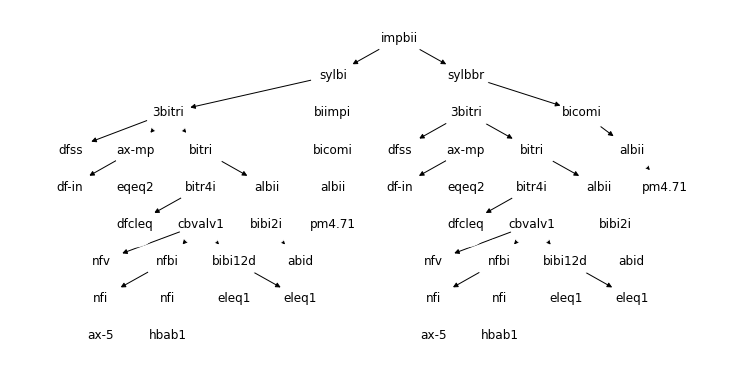

In [17]:
prop_proof = prop_proof.inputs[0].expand()
prop_proof.print_graph()

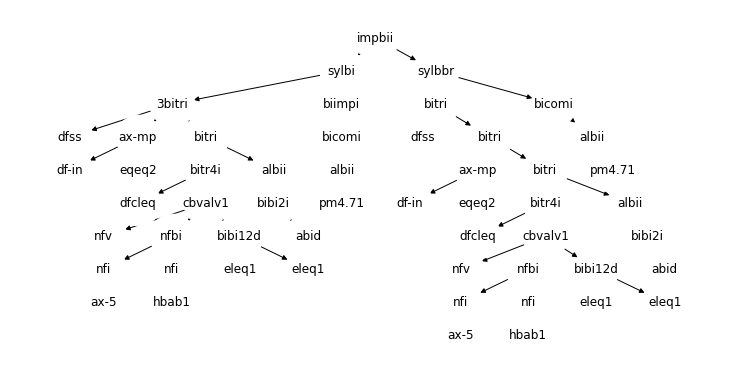

In [18]:
prop_proof.inputs[1].inputs[0].expand()
prop_proof.print_graph()

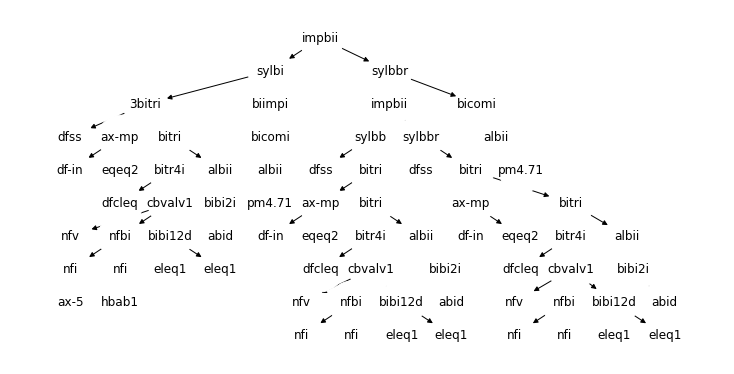

In [19]:
prop_proof.inputs[1].inputs[0].expand()
prop_proof.print_graph()

In [20]:
prop_proof.inputs[1].inputs[0].inputs[0].inputs[0].expand()

<PPStep:impbii ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>

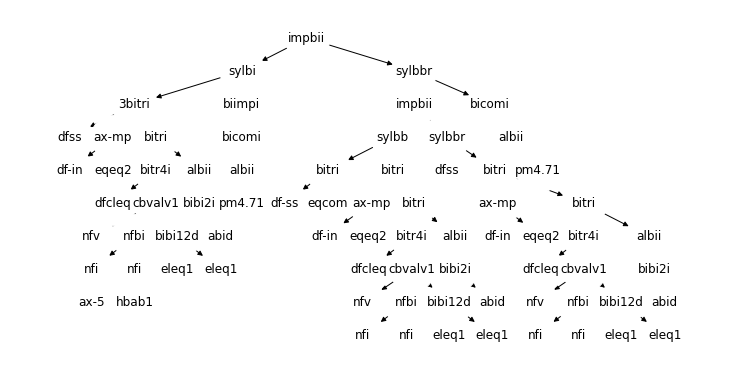

In [21]:
prop_proof.print_graph()

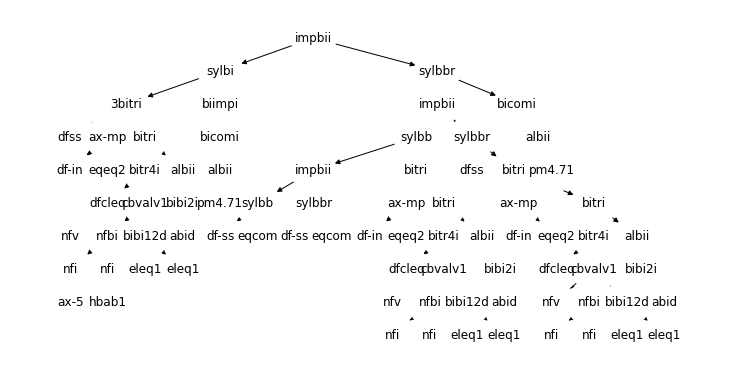

In [22]:
prop_proof.inputs[1].inputs[0].inputs[0].inputs[0].expand()
prop_proof.print_graph()

In [23]:
prop_proof.print_linear()

 <PPStep:impbii ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:sylbi ⊢ ( A ⊆ B → ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  |  <PPStep:ax-mp ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  |  <PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  |  |  <PPStep:eqeq2 ⊢ ( ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) } → ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  <PPStep:bitri ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  |  <PPStep:bitr4i ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ x ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  |  |  <PPStep:dfcleq ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ y ( y ∈ A ↔ y ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  |  |  <PPStep:cbvalv1 ⊢ ( ∀ x ( x ∈ A ↔ x ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) ↔ ∀ y ( y ∈ A ↔ y ∈ { x | ( x ∈ A ∧ x ∈ B ) } ) )>
 |  |  |  |  |  |  <PPStep:nfv ⊢ Ⅎ y ( x 